In [1]:
import glob
from astropy import table
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import	multiprocessing as mp
#from plotsettings_py36 import *
from scipy import interpolate
import scipy
import scipy.optimize
from scipy.optimize import curve_fit
import time
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# (Super) Functions

In [2]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [3]:
#lam is in angtroms 
#A_v is a user input

import extinction

A_v = 1.0

def Alam(lamin, A_v):

    lam=np.zeros(len(lamin))
    redreturn=np.zeros(len(lamin))

    #Add extinction with R_v= 3.1 and A_v = 1     
    extinction.ccm89(lam, A_v, 3.1)
        
    return redreturn


In [4]:
def select_templates(DATABASE, TYPES):

    
#    Selects templates of a given type(s) from a template database
    
#    Input: DATEBASE   list of templates
#           TYPES      which types should be selected
    
#    Output: array of templates of given type(s)
    
    database_trunc = list([])
    
    for type in TYPES:
        database_trunc += list([x for x in DATABASE if type in x])
    
    return np.array(database_trunc)

# Compute the (super) fit

In [5]:
def wrapper_fit(DATABASE):

    """
    Compute the fit
    """
   
    # 1) File i/o
    
    spec_gal    = np.loadtxt(DATABASE['GALAXY'])
    spec_SN     = np.loadtxt(DATABASE['SN'])
    spec_object = np.loadtxt(DATABASE['OBJECT'])
    spec_object[:,1]*=10
   
    # 2) Generate an error spectrum of the object spectrum
    
    """
    spec_object_even = spec_object[:,1][::2]
    spec_object_odd  = spec_object[:,1][1::2]

    if len(spec_object_even) > len(spec_object_odd):
        spec_object_odd += spec_object_even[-1]
    else:
        spec_object_even += spec_object_odd[-1]

    error_spectrum = []
   
    for i in range(len(spec_object_even)):
        error_spectrum.append(abs(spec_object_even[i]-spec_object_odd[i])/2.)
        error_spectrum.append(abs(spec_object_even[i]-spec_object_odd[i])/2.)
    
    if len(error_spectrum) == len(spec_SN):
        error_spectrum=np.array(error_spectrum).reshape((2800, 1))
        spec_object=np.append(spec_object, error_spectrum, axis=1)
    elif len(error_spectrum) > len(spec_SN):
        error_spectrum = np.array(error_spectrum)
        error_spectrum = error_spectrum.reshape((len(error_spectrum), 1))
        error_spectrum = error_spectrum[[np.arange(0,len(spec_object), 1)]]
        spec_object=np.append(spec_object, error_spectrum, axis=1)
    else:
        error_spectrum += error_spectrum[-1]
        error_spectrum=np.array(error_spectrum).reshape((2800, 1))
        spec_object=np.append(spec_object, error_spectrum, axis=1)    
    """
    # 3) Interpolate spectra
    
    spec_gal_interp    = interpolate.interp1d(spec_gal[:,0],    spec_gal[:,1],    bounds_error=False, fill_value=np.nan)
    spec_sn_interp     = interpolate.interp1d(spec_SN[:,0],     spec_SN[:,1],     bounds_error=False, fill_value=np.nan)
    spec_object_interp = interpolate.interp1d(spec_object[:,0], spec_object[:,1], bounds_error=False, fill_value=np.nan)
#   spec_object_err_interp = interpolate.interp1d(spec_object[:,0],     spec_object[:,2],     bounds_error=False, fill_value=np.nan)
    
    # Determine the common wavelength range
    
    lambda_min = max([spec_gal[:,0][0],  spec_SN[:,0][0],  spec_object[:,0][0]])
    lambda_max = min([spec_gal[:,0][-1], spec_SN[:,0][-1], spec_object[:,0][-1]])
    
    # Truncate wavelength interval
    
    lambda_new= spec_object[:,0][ (spec_object[:,0] >= lambda_min) & (spec_object[:,0] <= lambda_max) ]
    
    # 4) Fit function

    def func(x, b, d):
        return b * spec_sn_interp(x) + d * spec_gal_interp(x)

    # fitting
     
    result = curve_fit(func, lambda_new, spec_object_interp(lambda_new))
    print(result)
    popt   = result[0]
    pcov   = result[1]
    
    # Compute chi^2
    sigma  =1

    chi2   = np.sum(((spec_object_interp(lambda_new)-func(lambda_new, *popt))/sigma)**2)
    print(DATABASE['GALAXY'], DATABASE['SN'])

  
    output=table.Table(
            np.array([DATABASE['OBJECT'], DATABASE['GALAXY'], DATABASE['SN'], chi2, popt[0], popt[1], 0, 0, np.sqrt(pcov[0,0]), 0]), 
            names=('OBJECT', 'GALAXY', 'SN', 'CHI2', 'CONST_SN', 'CONST_GAL', 'CONST_EXT', 'CONST_GAL_ERR', 'CONST_SN_ERR', 'CONST_EXT_ERR'), 
            dtype=('S100', 'S100', 'S100', 'f', 'f', 'f', 'f', 'f', 'f', 'f'))
    
    
    return output
    

# Read in spectral database

In [67]:
#templates_gal = glob.glob('rebinned/gal/**/*')
templates_gal = glob.glob('rebinned/gal/Sb')
templates_gal = [x for x in templates_gal if 'CVS' not in x and 'README' not in x]
templates_gal = np.array(templates_gal)

templates_sn = glob.glob('rebinned/sne/Ia/sn1989b*')
templates_sn = [x for x in templates_sn if 'CVS' not in x and 'README' not in x]
templates_sn = np.array(templates_sn)

print(templates_sn)

#These parameters are user inputs 
templates_dust = np.array([-0.2, 0.1])

['rebinned/sne/Ia/sn1989b.p14.dat' 'rebinned/sne/Ia/sn1989b.m07.dat'
 'rebinned/sne/Ia/sn1989b.p17.dat' 'rebinned/sne/Ia/sn1989b.p03.dat'
 'rebinned/sne/Ia/sn1989b.m05.dat' 'rebinned/sne/Ia/sn1989b.p16.dat'
 'rebinned/sne/Ia/sn1989b.p12.dat' 'rebinned/sne/Ia/sn1989b.m01.dat'
 'rebinned/sne/Ia/sn1989b.p13.dat' 'rebinned/sne/Ia/sn1989b.p05.dat'
 'rebinned/sne/Ia/sn1989b.p11.dat' 'rebinned/sne/Ia/sn1989b.m03.dat'
 'rebinned/sne/Ia/sn1989b.m02.dat' 'rebinned/sne/Ia/sn1989b.p09.dat'
 'rebinned/sne/Ia/sn1989b.p08.dat' 'rebinned/sne/Ia/sn1989b.p18.dat'
 'rebinned/sne/Ia/sn1989b.p19.dat']


## Truncate templates SN, HG


In [68]:
#Here the SN 
templates_sn_trunc = select_templates(templates_sn, ['/Ia/'])

#Here the host galaxy
#templates_hg_trunc = select_templates(templates_hg, ['/S0/'])

# Compute the cartesian product of SN templates, galaxy templates and extinction measurements

In [69]:
cartesian_product_all=cartesian_product(*[templates_gal[:1], templates_sn_trunc, templates_dust[:1]])
cartesian_product_all=table.Table(cartesian_product_all, names=('GALAXY', 'SN', 'DUST'))

#In brakets here is the number of template I'm using to match
cartesian_product_all['OBJECT']=["sne/Ia/sn1989b.p16.Sb.dat"]
#cartesian_product_all['GALAXY']=["gal/Sb"]
#cartesian_product_all['SN']=["rebinned/sne/Ia/sn1989b.p16.dat"]

#cartesian_product_all['SN'][14]

#cartesian_product_all.pprint(max_lines=-1)

cartesian_product_all

GALAXY,SN,DUST,OBJECT
str32,str32,str32,str25
rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p14.dat,-0.2,sne/Ia/sn1989b.p16.Sb.dat
rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.m07.dat,-0.2,sne/Ia/sn1989b.p16.Sb.dat
rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p17.dat,-0.2,sne/Ia/sn1989b.p16.Sb.dat
rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p03.dat,-0.2,sne/Ia/sn1989b.p16.Sb.dat
rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.m05.dat,-0.2,sne/Ia/sn1989b.p16.Sb.dat
rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p16.dat,-0.2,sne/Ia/sn1989b.p16.Sb.dat
rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p12.dat,-0.2,sne/Ia/sn1989b.p16.Sb.dat
rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.m01.dat,-0.2,sne/Ia/sn1989b.p16.Sb.dat
rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p13.dat,-0.2,sne/Ia/sn1989b.p16.Sb.dat


In [70]:
index_array=range(len(cartesian_product_all))
index_array

range(0, 17)

In [71]:
output=wrapper_fit(cartesian_product_all[0])
output

(array([ 6.69579144, 14.86899589]), array([[ 0.15786651, -0.16782029],
       [-0.16782029,  0.21005785]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.p14.dat


OBJECT,GALAXY,SN,CHI2,CONST_SN,CONST_GAL,CONST_EXT,CONST_GAL_ERR,CONST_SN_ERR,CONST_EXT_ERR
bytes100,bytes100,bytes100,float32,float32,float32,float32,float32,float32,float32
sne/Ia/sn1989b.p16.Sb.dat,rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p14.dat,805.21,6.6957912,14.868996,0.0,0.0,0.39732417,0.0


In [72]:
if mp.cpu_count() > 1:
     number_cpu	= mp.cpu_count()/2	# is equal to number of threads x number of physical cpus, e.g. 2x4
else:
    number_cpu	= mp.cpu_count()
number_cpu
pool	= mp.Pool(processes=int(number_cpu)*2)


(array([ 6.69579144, 14.86899589]), array([[ 0.15786651, -0.16782029],
       [-0.16782029,  0.21005785]]))(array([10., 10.]), array([[ 1.48290448e-31, -1.77764681e-31],
       [-1.77764681e-31,  2.34403513e-31]]))(array([ 3.87527013, 17.82593952]), array([[ 0.17099743, -0.18363456],
       [-0.18363456,  0.25208192]]))

(array([ 0.60998276, 21.16220616]), array([[ 0.07031627, -0.09514815],
       [-0.09514815,  0.20888666]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.p14.dat
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.p17.dat

rebinned/gal/Sb rebinned/sne/Ia/sn1989b.p12.dat
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.m05.dat
(array([ 1.70785981, 20.18758567]), array([[ 0.19426206, -0.21076815],
       [-0.21076815,  0.30380784]]))(array([ 0.63234002, 21.16257217]), array([[ 0.07558586, -0.09861872],
       [-0.09861872,  0.20880825]]))

(array([ 0.38963717, 20.79604422]), array([[ 0.01529743, -0.04678138],
       [-0.04678138,  0.22118188]]))rebinned/gal/Sb rebinned/sne/Ia/sn1989b.p03.dat
rebin

In [73]:
result = pool.map(wrapper_fit, cartesian_product_all)

In [74]:
result=table.vstack(result)

In [75]:
result=[wrapper_fit(x) for x in cartesian_product_all]
result=table.vstack(result)

(array([ 6.69579144, 14.86899589]), array([[ 0.15786651, -0.16782029],
       [-0.16782029,  0.21005785]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.p14.dat
(array([ 0.63234002, 21.16257217]), array([[ 0.07558586, -0.09861872],
       [-0.09861872,  0.20880825]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.m07.dat
(array([10., 10.]), array([[ 1.48290448e-31, -1.77764681e-31],
       [-1.77764681e-31,  2.34403513e-31]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.p17.dat
(array([ 1.70785981, 20.18758567]), array([[ 0.19426206, -0.21076815],
       [-0.21076815,  0.30380784]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.p03.dat
(array([ 0.60998276, 21.16220616]), array([[ 0.07031627, -0.09514815],
       [-0.09514815,  0.20888666]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.m05.dat
(array([ 0.09031865, 21.86688698]), array([[ 0.00436626, -0.0058357 ],
       [-0.0058357 ,  0.08949686]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.p16.dat
(array([ 3.87527013, 17.82593952]), array([[ 0.17099743, -0.1836

In [76]:
result.sort('CHI2')
result

OBJECT,GALAXY,SN,CHI2,CONST_SN,CONST_GAL,CONST_EXT,CONST_GAL_ERR,CONST_SN_ERR,CONST_EXT_ERR
bytes100,bytes100,bytes100,float32,float32,float32,float32,float32,float32,float32
sne/Ia/sn1989b.p16.Sb.dat,rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p17.dat,5.529915e-28,10.0,10.0,0.0,0.0,3.85085e-16,0.0
sne/Ia/sn1989b.p16.Sb.dat,rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p19.dat,112.88399,9.772929,9.986964,0.0,0.0,0.17469804,0.0
sne/Ia/sn1989b.p16.Sb.dat,rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p18.dat,126.204506,9.872527,9.934587,0.0,0.0,0.18721567,0.0
sne/Ia/sn1989b.p16.Sb.dat,rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.m02.dat,467.96564,2.1349769,19.900902,0.0,0.0,1.2276208,0.0
sne/Ia/sn1989b.p16.Sb.dat,rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.m03.dat,474.73602,1.4527456,20.739313,0.0,0.0,0.99308217,0.0
sne/Ia/sn1989b.p16.Sb.dat,rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p14.dat,805.21,6.6957912,14.868996,0.0,0.0,0.39732417,0.0
sne/Ia/sn1989b.p16.Sb.dat,rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p13.dat,1045.6227,6.1493826,15.420562,0.0,0.0,0.45502296,0.0
sne/Ia/sn1989b.p16.Sb.dat,rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p11.dat,1067.6746,5.792548,15.766467,0.0,0.0,0.437533,0.0
sne/Ia/sn1989b.p16.Sb.dat,rebinned/gal/Sb,rebinned/sne/Ia/sn1989b.p09.dat,1414.7068,4.194828,17.39972,0.0,0.0,0.44316944,0.0


# (Super) Graph

In [93]:
def visualise_match(DATABASE):

    # File i/o
    
    spec_gal    = np.loadtxt(DATABASE['GALAXY'][0])
    spec_SN     = np.loadtxt(DATABASE['SN'][0])
    spec_object = np.loadtxt(DATABASE['OBJECT'][0])
    spec_object[:,1]*=10

    # Plot data
    """
    bestfit_galaxy = DATABASE['GALAXY'].split('/')[-1]
    bestfit_sn_name = DATABASE['SN'].split('/')[2].split('.')[0]
    bestfit_sn_type = DATABASE['SN'].split('/')[1]
    bestfit_sn_phase = '+' + DATABASE['SN'].split('/')[2].split('.')[1].replace('p', '') if 'p' in DATABASE['SN'].split('/')[2].split('.')[1] else '-' + DATABASE['SN'].split('/')[2].split('.')[1].replace('m', '')
    """
    
    plt.figure(figsize=(7*np.sqrt(2), 7))
    
    ax = plt.subplot(111)
    ax.plot(spec_object[:,0], spec_object[:,1], lw=4, label='Input spectrum')
    ax.plot(spec_gal[:,0], DATABASE['CONST_GAL'] * spec_gal[:,1], lw=1)#, label='Galaxy template: {}'.format(bestfit_galaxy))
    ax.plot(spec_SN[:,0],  DATABASE['CONST_SN']  * spec_SN[:,1],  lw=1)#, label='SN template: {name} ({type}, {phase} days)'.format(type=bestfit_sn_type, name=bestfit_sn_name, phase=bestfit_sn_phase))
    
#    ax.legend()#fontsize=legend_size-4)
    
    ax.set_xlabel('Observed wavelength (\\AA)')
    ax.set_ylabel('Flux density (arbitary units)')
    
    ax.set_xlim(spec_object[0,0]-20, spec_object[-1,0]-20)
    ax.set_ylim(0, max(spec_object[:,1])*1.2)
    
    plt.show()

In [94]:
result[0]['OBJECT']

'sne/Ia/sn1989b.p16.Sb.dat'

<Table length=1>
     name      dtype  
------------- --------
       OBJECT bytes100
       GALAXY bytes100
           SN bytes100
         CHI2  float32
     CONST_SN  float32
    CONST_GAL  float32
    CONST_EXT  float32
CONST_GAL_ERR  float32
 CONST_SN_ERR  float32
CONST_EXT_ERR  float32
None


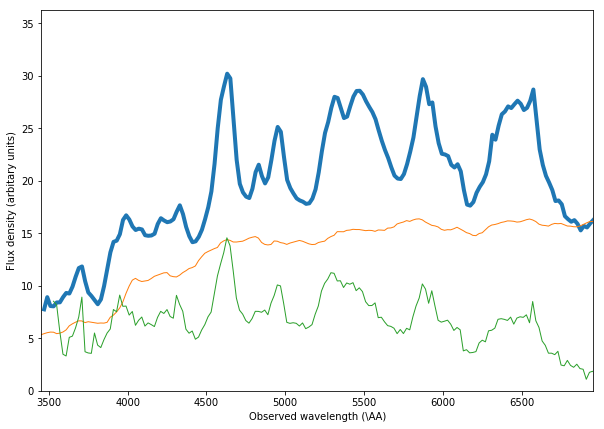

In [95]:
print(output.info())
visualise_match(table.Table(output))

In [90]:
import os
os.getcwd()

'/Users/user/Desktop/ssf/superfit'

In [91]:
[wrapper_fit(x) for x in cartesian_product_all]

(array([ 6.69579144, 14.86899589]), array([[ 0.15786651, -0.16782029],
       [-0.16782029,  0.21005785]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.p14.dat
(array([ 0.63234002, 21.16257217]), array([[ 0.07558586, -0.09861872],
       [-0.09861872,  0.20880825]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.m07.dat
(array([10., 10.]), array([[ 1.48290448e-31, -1.77764681e-31],
       [-1.77764681e-31,  2.34403513e-31]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.p17.dat
(array([ 1.70785981, 20.18758567]), array([[ 0.19426206, -0.21076815],
       [-0.21076815,  0.30380784]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.p03.dat
(array([ 0.60998276, 21.16220616]), array([[ 0.07031627, -0.09514815],
       [-0.09514815,  0.20888666]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.m05.dat
(array([ 0.09031865, 21.86688698]), array([[ 0.00436626, -0.0058357 ],
       [-0.0058357 ,  0.08949686]]))
rebinned/gal/Sb rebinned/sne/Ia/sn1989b.p16.dat
(array([ 3.87527013, 17.82593952]), array([[ 0.17099743, -0.1836

[<Table length=1>
           OBJECT               GALAXY     ... CONST_SN_ERR CONST_EXT_ERR
          bytes100             bytes100    ...   float32       float32   
 ------------------------- --------------- ... ------------ -------------
 sne/Ia/sn1989b.p16.Sb.dat rebinned/gal/Sb ...   0.39732417           0.0,
 <Table length=1>
           OBJECT               GALAXY     ... CONST_SN_ERR CONST_EXT_ERR
          bytes100             bytes100    ...   float32       float32   
 ------------------------- --------------- ... ------------ -------------
 sne/Ia/sn1989b.p16.Sb.dat rebinned/gal/Sb ...   0.27492884           0.0,
 <Table length=1>
           OBJECT               GALAXY     ... CONST_SN_ERR CONST_EXT_ERR
          bytes100             bytes100    ...   float32       float32   
 ------------------------- --------------- ... ------------ -------------
 sne/Ia/sn1989b.p16.Sb.dat rebinned/gal/Sb ...  3.85085e-16           0.0,
 <Table length=1>
           OBJECT               GALAX

In [92]:
#In order to identify the files giving me trouble

for file in np.unique(cartesian_product_all['SN']):
    try:
        np.loadtxt(file)
    except:
        print(file)


In [86]:
np.loadtxt('gal/Sb')

array([[1.100000e+03, 0.000000e+00],
       [1.104000e+03, 0.000000e+00],
       [1.108000e+03, 0.000000e+00],
       ...,
       [1.199200e+04, 2.602151e-14],
       [1.199600e+04, 2.602175e-14],
       [1.200000e+04, 2.602199e-14]])